In [210]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
import sys
import os
import pickle
sys.path.append("../vff")

from run_1d import main 
import torch

import itertools as it
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

# Get training data

## Runing Ising with double space to generate data for different L

We want to create a data set $\mathcal{D}\{x_i, \boldsymbol{y}_i\}$ where $x_i$ are the system sizes and $\boldsymbol{y}_i$ are the weights of the two layers. We fix the parameters of the Hamiltonian and time.

In [3]:
config = {
    # MODEL
    'L': 4,
    'hamiltonian': 'ising',
    't': 0.5,
    # TEBD
    'test_size': 100,  # number of states in test ensemble
    'tebd_test_steps': 20,  # number of steps in TEBD
    'max_bond': None,  # maximum bond dimension in tebd
    'tebd_cutoff': 1e-10,  # maximum bond dimension in tebd
    # 'ctg': True,
    # TRAINING
    'circuit_name': 'brickwall',
    'circuit_translation': True,  # translation invariant circuit
    'num_steps': 1000,  # maximum number of optimization steps
    'num_samples': 8,  # number of training samples
    'training_states': 'product',
    # STRATEGY`
    'training_strategy': 'double_space',
    # HOTSTART
    'depth': 2,  # maximum circuit depth
    'max_factor': 6,  # increase depth per step
    # OPTIMIZATION
    'learning_rate': 0.001,
    'learning_rate_schedule': lambda opt: torch.optim.lr_scheduler.StepLR(opt, step_size=200, gamma=0.5),
    # META
    'TRAIN': True,
    'TEST': True,
    'TEST_UNITARY': False,
    'PLOT': False,
    'SHOW': False,
    'SEED': 0
}

In [4]:
main(config)

Model ising of size 4 at time 0.500

TEBD steps: 10
TEBD max bond dimension: None
TEBD cutoff: 1e-10

(double_space) Depth = 2
(double_space) Max factor = 6

Circuit: brickwall
Translation: True
Type of training state: product
Number of steps: 1000
Number of samples: 8
Training strategy: double_space

Training for t=0.500 - L=4
Restored train dataset from file
TEBD error: 9.291884727795226e-06
DEPTH = 2
Data for depth 2 exists, loss = 0.029237315678277143
Test loss for 100 samples = 0.05471287912706968
Training for t=0.500 - L=8
Restored train dataset from file
TEBD error: 9.473363606013615e-06
DEPTH = 2
Data for depth 2 exists, loss = 0.02423532608808243
Test loss for 100 samples = 0.026522605403525135
Training for t=0.500 - L=16
Restored train dataset from file
TEBD error: 9.551145849378794e-06
DEPTH = 2
Data for depth 2 exists, loss = 0.055707587145647164
Test loss for 100 samples = 0.05900537219708857
Training for t=0.500 - L=32
Restored train dataset from file
TEBD error: 9.587341

# Creating dataset

In [204]:
config_path = config.copy()
config_path['GET_PATH'] = True
config_path['PRINT'] = False

save_path = main(config_path)
L_list = [2**i for i in range(2, config['max_factor']+2)]
depth = config['depth']
data_x = []
data_y = []
infidelities = []
for L in L_list:
    save_path_L = f"{save_path}/L_{L}/depth_{2}/ckpts/parameters.ckpt"
    fid = np.load(f"{save_path}/L_{L}/depth_{2}/test_loss_100.npy")
    infidelities.append(fid)
    # Input data x is the system size
    data_x.append(L)
    # Output are flattened parameters
    # Load parameters and flatten them
    parameters = torch.load(save_path_L)
    parameters_flattened = []
    for k in parameters.keys():
        pflat = np.array(parameters[k]).flatten()
        parameters_flattened.append(np.concatenate([pflat.real, pflat.imag]))
    data_y.append(np.stack(parameters_flattened))

## Let's look at the data

In [6]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(8,4)
for x,y in zip(data_x, data_y):
    axs[0].plot(y[0], label=f'L={x}')
    axs[0].set_title('Layer 1')
    axs[1].plot(y[1], label=f'L={x}')
    axs[1].set_title('Layer 2')
for ax in axs:
    ax.set_ylabel('$W_i')
    ax.set_ylabel('$i')
axs[0].legend()
plt.show()

Weights seem to converge to brown line and is in domain [-1,1]... Should be easy to learn. Let's split the training data in $L_{train}=4,8,16,32$ and $L_{test}= 64,128,$

In [7]:
from torch.utils.data import Dataset

In [8]:
data_y = [d.flatten() for d in data_y]
data_x_train, data_x_test = data_x[:4], data_x[4:]
data_y_train, data_y_test = data_y[:4], data_y[4:]
print(f"Train inputs: L = {data_x_train}")
print(f"Test inputs: L = {data_x_test}")
output_size = data_y_train[0].shape[0]
print(f"Output_size: {output_size}")
data_set_size = len(data_y_train)
print(f"Data set size: {data_set_size}")


Train inputs: L = [4, 8, 16, 32]
Test inputs: L = [64, 128]
Output_size: 64
Data set size: 4


# Creating a simple Neural Network

In [9]:
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader

import tqdm

In [174]:
class Net(nn.Module):
    def __init__(self, output_size):
      super(Net, self).__init__()
      self.dense_1 = nn.Linear(1, 100)
      self.dense_2 = nn.Linear(100, 100)
      self.dense_out = nn.Linear(100, output_size)
    # x represents our data
    def forward(self, x):
        # Pass data through conv1
      x = self.dense_1(x)
      # Use the rectified-linear activation function over x
      x = F.sigmoid(x)

      x = self.dense_2(x)
      x = F.sigmoid(x)
        
      x = self.dense_out(x)
      output = F.tanh(x)

      return output

In [175]:
model = Net(output_size)
test_output = model(torch.tensor(data_x_train, dtype=torch.float32)[:,None])
print(f"Output: {test_output[0]}")

Output: tensor([-0.1010,  0.0584,  0.4454, -0.3453,  0.2222, -0.0320,  0.1367,  0.2515,
        -0.1189,  0.2737,  0.3223,  0.2989, -0.1985, -0.2690, -0.0135,  0.1701,
        -0.1244, -0.2290, -0.0312,  0.0984, -0.1008, -0.0171,  0.1356,  0.2731,
        -0.2368,  0.2796,  0.0826,  0.3426,  0.1162,  0.0555,  0.2055,  0.1860,
        -0.0456, -0.1813, -0.0469,  0.1502,  0.1076,  0.3557, -0.4843,  0.2280,
         0.2714,  0.2094, -0.5756,  0.2366,  0.5385,  0.1739, -0.0430, -0.0529,
         0.1947, -0.1593,  0.2134,  0.1366,  0.3105,  0.6269,  0.0942, -0.1444,
         0.1521,  0.1880, -0.1107, -0.0475, -0.1395,  0.3023, -0.6750, -0.2109],
       grad_fn=<SelectBackward0>)


## Creating a Dataset instance in Torch

In [196]:
class MPSWeightDataset(Dataset):
    def __init__(self, x, y):
        self.data = torch.tensor(x, dtype=torch.float32)[:,None]
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

We're performing online learning, so there are no separate batches. For larger data sets, we may want to set the batch size to 64 to train the model in steps.

In [197]:
train_dataloader = DataLoader(MPSWeightDataset(data_x_train, data_y_train), batch_size=data_set_size)
test_dataloader = DataLoader(MPSWeightDataset(data_x_test, data_y_test), batch_size=data_set_size)

## Create training and test loop

In [198]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    return  test_loss / size


An epoch in Machine learning is one step where the model has seen all the data. We use an MSE combined with Adam to find the correct weights.

In [199]:
epochs = 1000
learning_rate = 1e-3
losses = []

loss_fn = nn.MSELoss()
model = Net(output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_loss = test_loop(test_dataloader, model, loss_fn)
print(f"Test loss before train: {test_loss}!")
pbar = tqdm.tqdm(range(epochs), bar_format="\t{l_bar}{bar:25}{r_bar}{bar:-25b}")
for step in pbar:
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    pbar.set_description(f"Train loss={loss}")
    losses.append(loss)
test_loss = test_loop(test_dataloader, model, loss_fn)
print(f"Test loss after train: {test_loss}!")

Test loss before train: 0.09271930903196335!


	Train loss=2.0497715013334528e-05: 100%|█████████████████████████| 1000/1000 [00:01<00:00, 937.40it/s]                                                                                                                  

Test loss after train: 3.5051223676418886e-05!


3.5051223676418886e-05


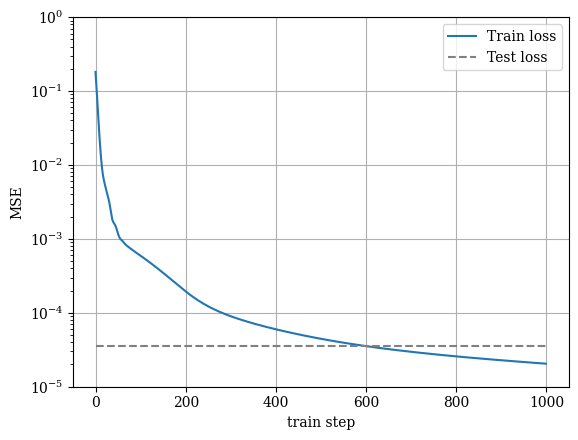

In [226]:
plt.plot(np.abs(losses), label='Train loss')
print(test_loss)
plt.hlines(test_loss, 0, 1000, label='Test loss', color='gray',linestyle='dashed')
plt.xlabel('train step')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.ylim([1e-5, 1])
plt.grid()
plt.savefig("loss.png")

We see that we can quickly train the model to predict the correct weights for $L_{train}=4,8,16,32$. The test loss indicates that we can then produce the weights for $L_{test}= 64,128,$ with very high accuracy, even though they were never seen in the training data. The test loss is higher because we overfit on the test data.

# Predicting new weights for L=256

In [200]:
from tn.mps_circuit import TNModel, qmps_brick, qmps_brick_quasi_1d, create_targets, load_gates
from tn.data_states import random_product_state, \
    random_mps_state, get_make_data_set_fn, random_U1_state
from tn.tebd import ising_hamiltonian_quimb, \
    longitudinal_ising_hamiltonian_quimb, \
    heisenberg_hamiltonian_quimb, \
    mbl_hamiltonian_quimb
from tn.trotter import trotter_evolution_optimized_nn_ising_tn

We can now use the model to predict weights for other system sizes:

In [201]:
new_L = 256
new_L_weights= model(torch.tensor([new_L], dtype=torch.float32)[:,None])
new_L_weights_split = np.split(new_L_weights.detach().numpy().flatten(), config['depth']*2)
predicted_parameters = []
for i in range(0, config['depth']*2,2):
    predicted_parameters.append(torch.tensor(new_L_weights_split[i].reshape([2]*4)+1j*new_L_weights_split[i+1].reshape([2]*4)))

In [202]:
SEED = config['SEED']
hamiltonian = config['hamiltonian']
t = config['t']
depth = config['depth']
num_samples = 20
circuit_translation =  config['circuit_translation']

g = config.get('g', 1.0)
tebd_cutoff = config.get('tebd_cutoff', -1)  # What is the SVD cutoff for TEBD
tebd_max_bond = config.get('max_bond', 20)  # What is the bond dimension cutoff for TEBD
tebd_opts = {'cutoff': tebd_cutoff, 'max_bond': tebd_max_bond}

tebd_granularity =  int(np.round(t / 0.05))
H = lambda x: ising_hamiltonian_quimb(x, 1.0, g)
get_training_state = lambda x, s: random_product_state(x, s)

make_data_set = get_make_data_set_fn(hamiltonian, H(new_L), tebd_granularity, tebd_opts, False)
psi0_list_train, psit_list_train, tebd_errors = make_data_set(lambda x: get_training_state(new_L, x),
                                                              t,
                                                              num_samples, SEED)
psi_pqc = qmps_brick(new_L, in_depth=depth, rand=False, val_iden=0.01)
psi, psi_tars = create_targets(new_L, psi_pqc, psi0_list_train, psit_list_train, device='cpu')
mps_model = TNModel(psi, psi_tars, translation=circuit_translation)

In [206]:
print("Inidelity before:", mps_model())
par_names = [f"torch_params.{i}" for i in range(config['depth'])]
param_dict = dict(zip(par_names, predicted_parameters))
mps_model.load_state_dict(param_dict, strict=True)
mps_model.eval()
predicted_infidelity = mps_model()
print("Infidelity with predicted weights:", mps_model())

Inidelity before: tensor(0.6797, dtype=torch.float64, grad_fn=<RsubBackward1>)
Infidelity with predicted weights: tensor(0.6797, dtype=torch.float64, grad_fn=<RsubBackward1>)


We get a reasonable infidelity for 

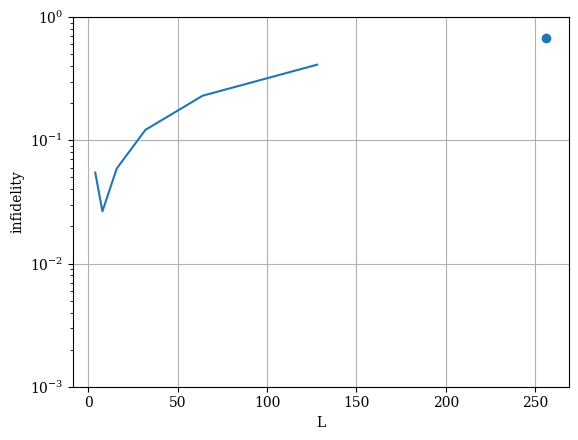

In [227]:
plt.plot(L_list, infidelities)
plt.scatter(new_L, predicted_infidelity.detach().numpy())
plt.xlabel('L')
plt.ylabel('infidelity')
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.grid()
plt.savefig("infidelity.png")
plt.show()

Seems like a reasonable fidelity!